In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# =============================================================
# 0. 환경 준비
# =============================================================
import os, random, numpy as np, matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm
from PIL import Image

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import roc_auc_score, average_precision_score

IMG_SIZE    = 128
BATCH_SIZE  = 32
EPOCHS      = 5
LR          = 1e-3
ROOT_DIR    = '/content/drive/MyDrive/Data/MVTecAD'
SAVE_PATH   = 'best_ae_mvtecad.pt'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('✅ device:', DEVICE)


✅ device: cuda


In [3]:
# =============================================================
# 1. 데이터셋 & DataLoader
#         – train  : 모든 */train/good
#         – test   : */test/good + */test/<defect>/*
# =============================================================
class MVTecADMulti(Dataset):
    def __init__(self, root_dir:str, phase:str='train'):
        assert phase in ('train', 'test')
        self.phase = phase
        self.paths = []                      # [(img_path, label)]
        for cat in sorted(os.listdir(root_dir)):
            cat_path = Path(root_dir)/cat
            if not cat_path.is_dir():
                continue
            if phase == 'train':
                self.paths += [(p, 0) for p in glob(str(cat_path/'train'/'good'/'*.png'))]
            else:
                self.paths += [(p, 0) for p in glob(str(cat_path/'test'/'good'/'*.png'))]
                for defect in os.listdir(cat_path/'test'):
                    if defect == 'good': continue
                    self.paths += [(p, 1) for p in glob(str(cat_path/'test'/defect/'*.png'))]
        self.tf = T.Compose([
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p, lbl = self.paths[idx]
        img = Image.open(p).convert('RGB')   # ← 핵심
        img = self.tf(img)
        return img, lbl, p

def get_loaders(root):
    train_ds = MVTecADMulti(root, 'train')
    test_ds  = MVTecADMulti(root, 'test')
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True, drop_last=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = get_loaders(ROOT_DIR)
print(f"Train:{len(train_loader.dataset)}  Test:{len(test_loader.dataset)}")


Train:3629  Test:1725


In [4]:
# =============================================================
# 2.  네트워크 (Convolutional Autoencoder)
# =============================================================
class Encoder(nn.Module):
    def __init__(self, base=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, base, 4, 2, 1), nn.BatchNorm2d(base), nn.ReLU(True),
            nn.Conv2d(base, base*2, 4, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(True),
            nn.Conv2d(base*2, base*4, 4, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(True),
            nn.Conv2d(base*4, base*8, 4, 2, 1), nn.BatchNorm2d(base*8), nn.ReLU(True),
        )
    def forward(self, x): return self.enc(x)

class Decoder(nn.Module):
    def __init__(self, base=64):
        super().__init__()
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(base*8, base*4, 4, 2, 1), nn.BatchNorm2d(base*4), nn.ReLU(True),
            nn.ConvTranspose2d(base*4, base*2, 4, 2, 1), nn.BatchNorm2d(base*2), nn.ReLU(True),
            nn.ConvTranspose2d(base*2, base,   4, 2, 1), nn.BatchNorm2d(base),   nn.ReLU(True),
            nn.ConvTranspose2d(base,   3,      4, 2, 1), nn.Tanh()
        )
    def forward(self, z): return self.dec(z)

class AutoEncoder(nn.Module):
    def __init__(self, base=64):
        super().__init__()
        self.encoder = Encoder(base)
        self.decoder = Decoder(base)
    def forward(self, x):
        z = self.encoder(x)
        rec = self.decoder(z)
        return rec

model = AutoEncoder().to(DEVICE)
print(f'총 파라미터 수: {sum(p.numel() for p in model.parameters())/1e6:.1f}M')


총 파라미터 수: 5.5M


In [5]:
# =============================================================
# 3.  학습 루프
# =============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
best_ap = 0

for epoch in range(EPOCHS):
    model.train();  train_loss = 0
    for imgs, _, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        imgs = imgs.to(DEVICE)
        recons = model(imgs)
        loss = F.l1_loss(recons, imgs)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()*imgs.size(0)
    scheduler.step()

    # -------- 검증 (AP 기준 Early-Stop) --------
    model.eval();  errs, labels = [], []
    with torch.no_grad():
        for imgs, lbls, _ in test_loader:
            imgs = imgs.to(DEVICE)
            recons = model(imgs)
            err = F.mse_loss(recons, imgs, reduction='none')
            err = err.flatten(1).mean(1).cpu().numpy()
            errs.append(err); labels.append(lbls.numpy())
    errs   = np.concatenate(errs)
    labels = np.concatenate(labels)
    ap  = average_precision_score(labels, errs)
    auc = roc_auc_score(labels, errs)
    print(f'  ▸ TrainLoss={train_loss/len(train_loader.dataset):.4f}  AP={ap:.4f}  ROC-AUC={auc:.4f}')

    if ap > best_ap:
        best_ap = ap
        torch.save(model.state_dict(), SAVE_PATH)
        print(f'  ✔ Best model saved @ AP {best_ap:.4f}')


Epoch 1/5: 100%|██████████| 113/113 [10:07<00:00,  5.38s/it]


  ▸ TrainLoss=0.1935  AP=0.7016  ROC-AUC=0.4587
  ✔ Best model saved @ AP 0.7016


Epoch 2/5: 100%|██████████| 113/113 [01:17<00:00,  1.46it/s]


  ▸ TrainLoss=0.1306  AP=0.7115  ROC-AUC=0.4758
  ✔ Best model saved @ AP 0.7115


Epoch 3/5: 100%|██████████| 113/113 [01:12<00:00,  1.55it/s]


  ▸ TrainLoss=0.1143  AP=0.7561  ROC-AUC=0.5119
  ✔ Best model saved @ AP 0.7561


Epoch 4/5: 100%|██████████| 113/113 [01:12<00:00,  1.56it/s]


  ▸ TrainLoss=0.1058  AP=0.7212  ROC-AUC=0.4839


Epoch 5/5: 100%|██████████| 113/113 [01:11<00:00,  1.58it/s]


  ▸ TrainLoss=0.0925  AP=0.7297  ROC-AUC=0.4914


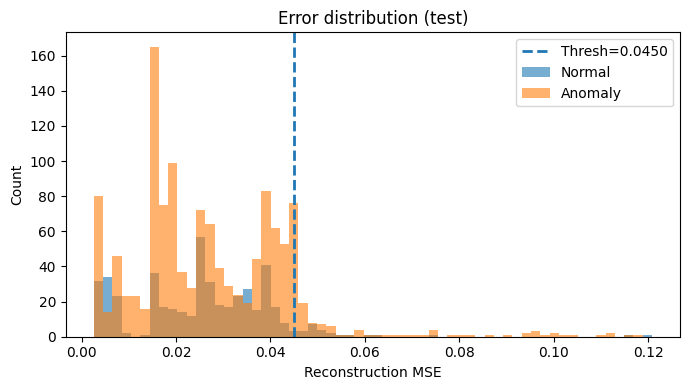

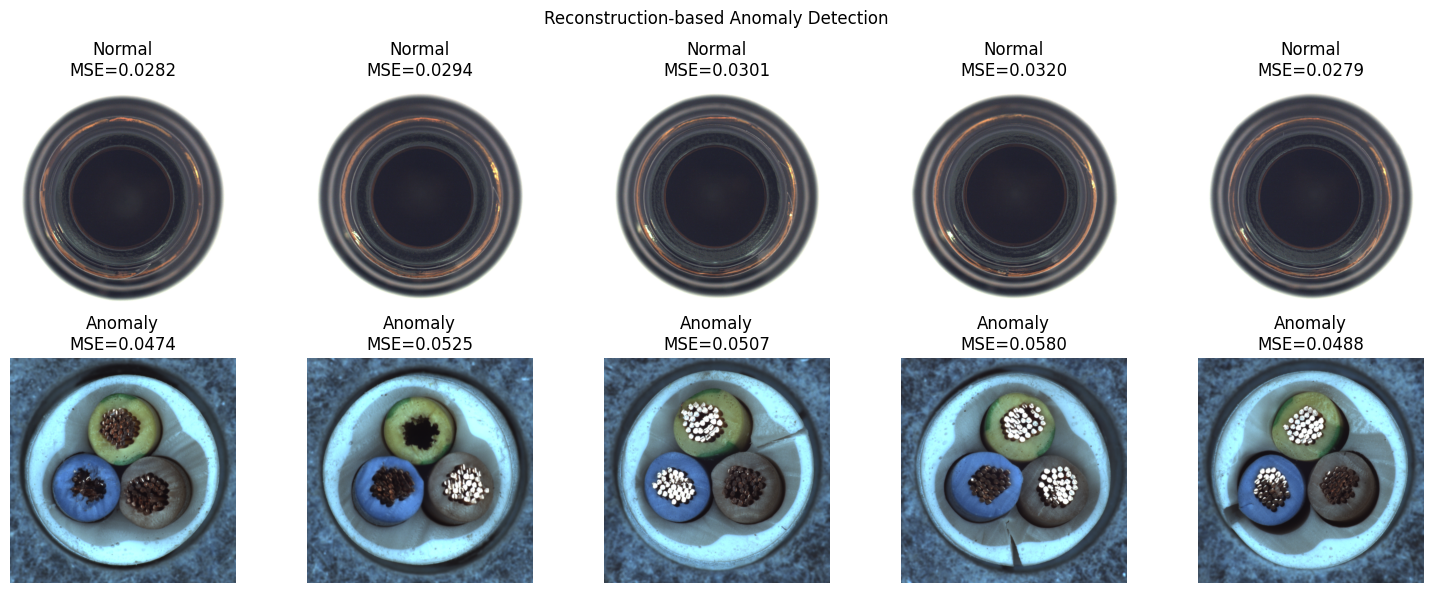

In [6]:
# =============================================================
# 4.  테스트 & 시각화
#         – (1) 에러 분포 히스토그램
#         – (2) 정상∙이상 예시 5×2장
# =============================================================
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()

# (1) 에러 계산
errs, labels, paths = [], [], []
with torch.no_grad():
    for imgs, lbls, ps in test_loader:
        imgs = imgs.to(DEVICE)
        recons = model(imgs)
        err = F.mse_loss(recons, imgs, reduction='none')
        err = err.flatten(1).mean(1).cpu().numpy()
        errs.append(err); labels.append(lbls.numpy()); paths += ps
errs = np.concatenate(errs); labels = np.concatenate(labels)

# 95-percentile 기준 임계값
THRESH = np.percentile(errs[labels==0], 95)

# (1-a) 히스토그램
hist_n, edges_n = np.histogram(errs[labels==0], bins=60)
hist_a, _       = np.histogram(errs[labels==1], bins=edges_n)
centers = (edges_n[:-1] + edges_n[1:]) / 2

plt.figure(figsize=(7,4))
plt.bar(centers, hist_n, width=centers[1]-centers[0], label='Normal', alpha=.6)
plt.bar(centers, hist_a, width=centers[1]-centers[0], label='Anomaly', alpha=.6)
plt.axvline(THRESH, ls='--', lw=2, label=f'Thresh={THRESH:.4f}')
plt.xlabel('Reconstruction MSE'); plt.ylabel('Count')
plt.title('Error distribution (test)'); plt.legend(); plt.tight_layout(); plt.show()

# (2) 예시 이미지 시각화
def denorm(x): return x.mul(0.5).add(0.5).clamp(0,1)
idx_norm = np.where((labels==0) & (errs<THRESH))[0][:5]
idx_anom = np.where((labels==1) & (errs>THRESH))[0][:5]
sel = np.concatenate([idx_norm, idx_anom])

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, ax in enumerate(axes.flatten()):
    img = plt.imread(paths[sel[i]])[:,:,:3]
    ax.imshow(img); ax.axis('off')
    ax.set_title(f"{'Normal' if i<5 else 'Anomaly'}\nMSE={errs[sel[i]]:.4f}")
plt.suptitle('Reconstruction-based Anomaly Detection'); plt.tight_layout(); plt.show()
